In [13]:
from openimages.download import download_dataset
import os
import shutil
from sklearn.model_selection import train_test_split
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [18]:
TRAIN = True
EPOCHS = 25

## Download and Split the Data

In [3]:
# select classes to be downloaded
class_names = ["Alpaca"]

# download the images and annotations for the specified classes
if __name__ == "__main__":
    download_dataset(dest_dir='data/', class_labels=class_names, annotation_format='darknet', limit=200)

2024-07-01  13:09:33 INFO Downloading 94 train images for class 'alpaca'
100%|██████████| 94/94 [00:08<00:00, 11.60it/s]
2024-07-01  13:09:41 INFO Creating 94 train annotations (darknet) for class 'alpaca'
100%|██████████| 94/94 [00:00<00:00, 220.05it/s]
2024-07-01  13:09:45 INFO Downloading 14 validation images for class 'alpaca'
100%|██████████| 14/14 [00:01<00:00,  7.61it/s]
2024-07-01  13:09:47 INFO Creating 14 validation annotations (darknet) for class 'alpaca'
100%|██████████| 14/14 [00:00<00:00, 40.12it/s]
2024-07-01  13:09:52 INFO Downloading 34 test images for class 'alpaca'
100%|██████████| 34/34 [00:04<00:00,  8.29it/s]
2024-07-01  13:09:56 INFO Creating 34 test annotations (darknet) for class 'alpaca'
100%|██████████| 34/34 [00:00<00:00, 92.31it/s]


In [5]:
# define paths to images and labels
base_dir = 'data/alpaca'
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

# count the number of files in each directory
num_images = len([name for name in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, name))])
num_labels = len([name for name in os.listdir(labels_dir) if os.path.isfile(os.path.join(labels_dir, name))])

print(f"Number of images: {num_images}")
print(f"Number of labels: {num_labels}")

Number of images: 142
Number of labels: 142


In [6]:
# create subdirectories
subdirs = ['train', 'validation', 'test']
for subdir in subdirs:
    os.makedirs(os.path.join(images_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, subdir), exist_ok=True)

In [7]:
# set list of files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

# sort the files to ensure matching
image_files.sort()
label_files.sort()

In [8]:
# TODO: change test set proportions
# split the data
train_images, temp_images, train_labels, temp_labels = train_test_split(image_files, label_files, test_size=0.15, random_state=42)
validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.15, random_state=42)

In [10]:
# function to move files to respective directories
def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(src_dir, file), os.path.join(dest_dir, file))

In [11]:
# move the files to new directories
move_files(train_images, images_dir, os.path.join(images_dir, 'train'))
move_files(validation_images, images_dir, os.path.join(images_dir, 'validation'))
move_files(test_images, images_dir, os.path.join(images_dir, 'test'))

move_files(train_labels, labels_dir, os.path.join(labels_dir, 'train'))
move_files(validation_labels, labels_dir, os.path.join(labels_dir, 'validation'))
move_files(test_labels, labels_dir, os.path.join(labels_dir, 'test'))

## Data Exploration

In [12]:
def yolo_to_bbox(yolo_bbox, img_width, img_height):
    """
    Convert YOLO bounding box format to [xmin, ymin, width, height] format.
    """
    class_id, x_center, y_center, width, height = map(float, yolo_bbox.split())
    xmin = (x_center - width / 2) * img_width
    ymin = (y_center - height / 2) * img_height
    bbox_width = width * img_width
    bbox_height = height * img_height

    return class_id, xmin, ymin, bbox_width, bbox_height

In [14]:
def visualize_bounding_boxes(image_path, label_path):
    """
    Visualize bounding boxes on the image.
    """
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = image.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Read bounding box annotations
    with open(label_path, 'r') as f:
        bboxes = f.readlines()

    # Plot each bounding box
    for bbox in bboxes:
        class_id, xmin, ymin, bbox_width, bbox_height = yolo_to_bbox(bbox, img_width, img_height)
        rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [15]:
def get_first_n_files(directory, n):
    """
    Get the first n files in the directory sorted by their names.
    """
    files = sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return files[:n]

In [16]:
def process_files(image_dir, label_dir, n):
    """
    Process the first n files in the directory.
    """
    # Get the first n files from the image and label directories
    image_files = get_first_n_files(image_dir, n)
    label_files = get_first_n_files(label_dir, n)

    for image_file, label_file in zip(image_files, label_files):
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, label_file)
        print(f"Processing {image_path} and {label_path}")
        visualize_bounding_boxes(image_path, label_path)

Processing data/alpaca/images/train/01ad3ff1d94eb557.jpg and data/alpaca/labels/train/01ad3ff1d94eb557.txt


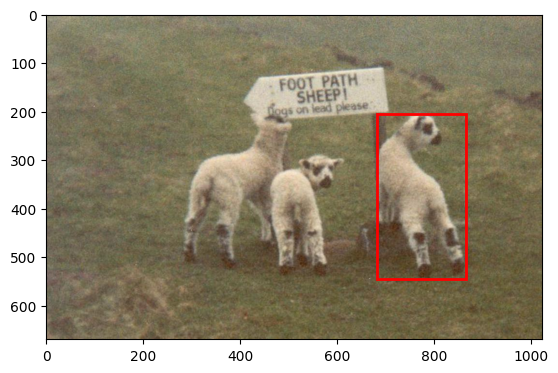

Processing data/alpaca/images/train/0346463867a297f4.jpg and data/alpaca/labels/train/0346463867a297f4.txt


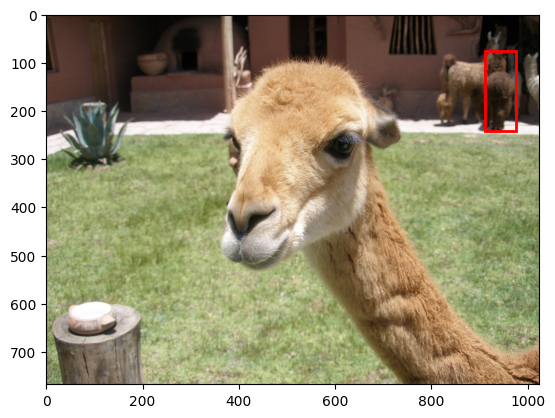

Processing data/alpaca/images/train/038fae9e70c4c3f1.jpg and data/alpaca/labels/train/038fae9e70c4c3f1.txt


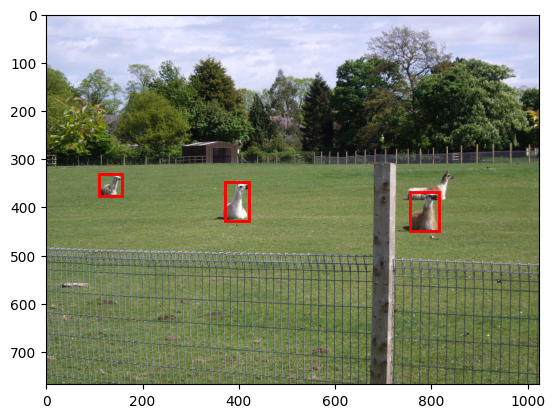

Processing data/alpaca/images/train/053608552d63f724.jpg and data/alpaca/labels/train/053608552d63f724.txt


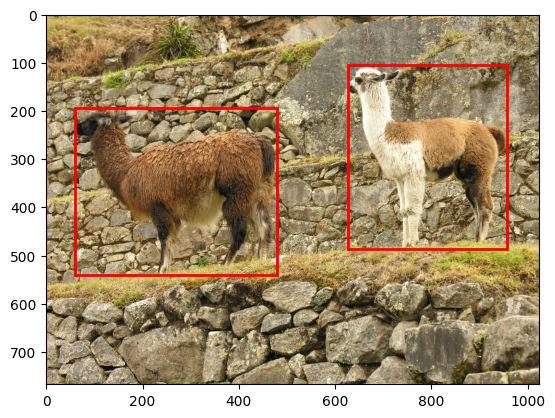

Processing data/alpaca/images/train/053dab62fbb47736.jpg and data/alpaca/labels/train/053dab62fbb47736.txt


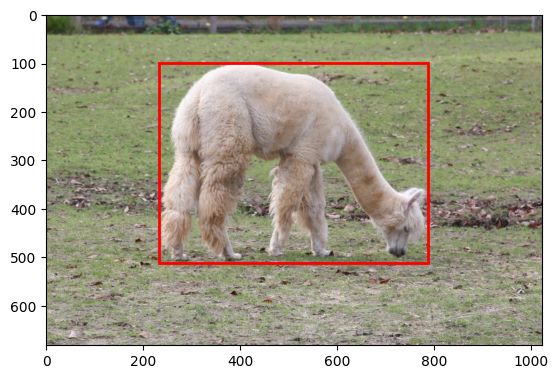

In [17]:
# select directories and number of images
image_dir = 'data/alpaca/images/train'
label_dir = 'data/alpaca/labels/train'
n = 5

# visualize
process_files(image_dir, label_dir, n)

## Helper Functions for Logging

In [19]:
def set_res_dir():
    # directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [20]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOv5 Repository

In [21]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16725, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 16725 (delta 138), reused 152 (delta 80), pack-reused 16459
Receiving objects: 100% (16725/16725), 15.39 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (11437/11437), done.


In [22]:
%cd yolov5/
!pwd

/Users/ivanosipchyk/dev/studies/yolo-fine-tuning/yolov5
/Users/ivanosipchyk/dev/studies/yolo-fine-tuning/yolov5


In [23]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 11.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.3/883.3 kB 12.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 18.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 14.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━